In [13]:
"""
from roboflow import Roboflow
rf = Roboflow(api_key="7MVRqtyrhYbXeUs0gDxI")
project = rf.workspace("sonpt").project("panel-extraction")
version = project.version(3)
dataset = version.download("voc")
"""

'\nfrom roboflow import Roboflow\nrf = Roboflow(api_key="7MVRqtyrhYbXeUs0gDxI")\nproject = rf.workspace("sonpt").project("panel-extraction")\nversion = project.version(3)\ndataset = version.download("voc")\n'

In [1]:
import tensorflow as tf
import os
from xml.etree import ElementTree
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2024-11-10 14:57:39.003932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 14:57:39.022187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 14:57:39.027515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 14:57:39.040394: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 14:57:39.931464: W tensorflow/compiler/tf2

In [2]:
def parse_xml_to_mask(xml_path, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    tree = ElementTree.parse(xml_path)
    root = tree.getroot()
    
    for obj in root.findall('object'):
        polygon = obj.find('polygon')
        points = []
        
        # Extract points by parsing the x1, y1, x2, y2, etc. fields
        i = 1
        while True:
            x_tag = f'x{i}'
            y_tag = f'y{i}'
            x = polygon.find(x_tag)
            y = polygon.find(y_tag)
            
            if x is None or y is None:
                break  # No more points

            try:
                # Convert the text to integer points
                x = int(float(x.text))
                y = int(float(y.text))
                points.append((x, y))
            except Exception as e:
                print(f"Error parsing point {x_tag}, {y_tag} in {xml_path}: {e}")
            
            i += 1

        if points:  # Ensure points list is not empty
            points = np.array(points, dtype=np.int32)
            cv2.fillPoly(mask, [points], color=1)  # Fill the polygon with 1s in the mask
        else:
            print(f"No points found for an object in {xml_path}")

    return mask

# Function to load images and their corresponding masks
def load_images_and_masks(folder_path,image_size=(384, 384)):
    images = []
    masks = []
    
    # List all jpg files and sort them to ensure consistent ordering
    jpg_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])

    for jpg_file in jpg_files:
        # Load image
        img_path = os.path.join(folder_path, jpg_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Warning: Image file {jpg_file} could not be loaded.")
            continue
        
        # Load corresponding mask
        xml_file = jpg_file.replace('.jpg', '.xml')
        xml_path = os.path.join(folder_path, xml_file)
        
        if os.path.exists(xml_path):
            # Parse XML to create mask with the original shape of the image
            mask = parse_xml_to_mask(xml_path, img.shape)  # Generates a mask that matches the original image size
            
            # Resize both image and mask to the target size after loading
            img_resized = cv2.resize(img, image_size)
            mask_resized = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
            
            # Normalize the image and ensure the mask is binary
            img_resized = img_resized / 255.0  # Normalize to 0-1
            mask_resized = (mask_resized > 0.5).astype(np.uint8)  # Ensure binary mask
            
            images.append(img_resized)
            masks.append(mask_resized[..., np.newaxis])  # Add channel dimension for mask
        else:
            print(f"Warning: No XML file found for {jpg_file}")
    
    return np.array(images), np.array(masks)


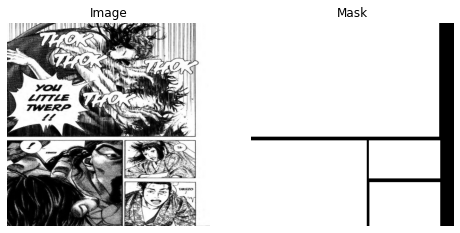

In [3]:
images, masks = load_images_and_masks('Panel-extraction-2/train')

# Visualize a specific image-mask pair
index = 11 # Change this to check different images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(images[index])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(masks[index].squeeze(), cmap='gray')
plt.axis('off')

plt.show()


In [4]:
masks[0].shape

(384, 384, 1)

In [5]:
def visualize_mask_from_xml(xml_path, image_shape=(640, 640)):
    """
    Visualizes the mask generated from a specific XML file.
    
    Parameters:
    - xml_path: The file path to the XML annotation file.
    - image_shape: The original shape of the mask (height, width) as expected from annotations.
    """
    # Generate mask from XML file
    mask = parse_xml_to_mask(xml_path, image_shape)
    
    # Display the mask
    plt.figure(figsize=(6, 6))
    plt.title("Mask from XML")
    plt.imshow(mask, cmap='gray')
    plt.axis('off') 
    plt.show()

# Example usage
#xml_path = r'C:\Users\Pham Thai Son\Desktop\New folder\Panel-extraction-3\train\data_moi_18_9-160_jpg.rf.0d8bd92667dd3f5567a07a7189b6d388.xml'  # Replace with actual path
#visualize_mask_from_xml(xml_path, image_shape=(640, 640))

In [42]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

def unet_model(input_size=(384, 384, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    
    # Decoder
    up2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up2 = concatenate([up2, conv2])
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up1 = concatenate([up1, conv1])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    
    model = Model(inputs, outputs)
    return model

In [ ]:
# Load data
train_images, train_masks = load_images_and_masks('Panel-extraction-2/train')
valid_images, valid_masks = load_images_and_masks('Panel-extraction-2/valid')

# Initialize model
model = unet_model(input_size=(384, 384, 3))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision'])

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model_4.keras',  # Filepath to save the model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Save when validation loss decreases
    save_best_only=True,  # Only save the best model
    verbose=1  # Print a message when a new best model is saved
)

# Train model with the checkpoint
history = model.fit(
    train_images, train_masks,
    validation_data=(valid_images, valid_masks),
    batch_size=16,
    epochs=250,
    callbacks=[checkpoint]  
)


In [6]:
test_images, test_masks = load_images_and_masks('Panel-extraction-2/test')

def calculate_pixel_accuracy_no_post_processing(pred_mask, true_mask, threshold=0.5):
    # Convert predictions to binary mask based on threshold
    pred_binary = (pred_mask > threshold).astype(np.uint8)
    true_binary = (true_mask > 0.5).astype(np.uint8)  # Ensure true mask is binary

    # Calculate the number of correct pixels
    correct_pixels = np.sum(pred_binary == true_binary)

    # Calculate total number of pixels
    total_pixels = true_mask.size

    # Pixel accuracy as a ratio of correct pixels to total pixels
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

def plot_predictions_no_post_processing(image, true_mask, pred_mask, threshold=0.5):
    # Threshold the prediction mask
    pred_binary = (pred_mask > threshold).astype(np.uint8)

    # Plot the input image, ground truth mask, and raw predicted mask
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Raw Predicted Mask")
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

# Iterate through a few test samples
pixel_accuracies = []
for i in range(5):  # Adjust as needed
    img = test_images[i]
    true_mask = test_masks[i]

    # Generate prediction
    pred_mask = model.predict(img[np.newaxis, ...])[0]

    # Calculate Pixel Accuracy without post-processing
    pixel_accuracy = calculate_pixel_accuracy_no_post_processing(pred_mask, true_mask)
    pixel_accuracies.append(pixel_accuracy)
    
    # Display results
    print(f"Sample {i+1} - Pixel Accuracy: {pixel_accuracy:.4f}")
    plot_predictions_no_post_processing(img, true_mask, pred_mask)

# Print average pixel accuracy across samples
print(f"Average Pixel Accuracy: {np.mean(pixel_accuracies):.4f}")

NameError: name 'model' is not defined

In [7]:
def post_process_mask(mask, threshold=0.5):
    # Apply thresholding to convert probabilities to binary values
    binary_mask = (mask > threshold).astype(np.uint8)

    # Optional: Use morphological operations to remove small noise or smooth the mask
    kernel = np.ones((3, 3), np.uint8)
    processed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)  # Close small holes
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_OPEN, kernel)  # Remove noise

    return processed_mask

In [ ]:
def plot_predictions(image, true_mask, pred_mask, threshold=0.5):
    # Post-process the predicted mask
    processed_mask = post_process_mask(pred_mask, threshold=threshold)

    # Plot the input image, ground truth mask, and processed mask
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Processed Predicted Mask")
    plt.imshow(processed_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()


In [ ]:
def calculate_pixel_accuracy(pred_mask, true_mask):
    # Calculate the number of correct pixels
    correct_pixels = np.sum(pred_mask == true_mask)

    # Calculate total pixels
    total_pixels = pred_mask.size

    # Pixel accuracy as a ratio of correct pixels to total pixels
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy


In [8]:
model_250= tf.keras.models.load_model('best_model_3.keras')

I0000 00:00:1731225614.775939 3290259 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731225614.823523 3290259 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731225614.823762 3290259 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731225614.825065 3290259 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [9]:
def parse_xml_to_mask(xml_path, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    tree = ElementTree.parse(xml_path)
    root = tree.getroot()
    
    for obj in root.findall('object'):
        polygon = obj.find('polygon')
        points = []
        
        i = 1
        while True:
            x_tag = f'x{i}'
            y_tag = f'y{i}'
            x = polygon.find(x_tag)
            y = polygon.find(y_tag)
            
            if x is None or y is None:
                break

            try:
                x = int(float(x.text))
                y = int(float(y.text))
                points.append((x, y))
            except Exception as e:
                print(f"Error parsing point {x_tag}, {y_tag} in {xml_path}: {e}")
            
            i += 1

        if points:
            points = np.array(points, dtype=np.int32)
            cv2.fillPoly(mask, [points], color=1)
        else:
            print(f"No points found for an object in {xml_path}")

    return mask

def load_images_and_masks(folder_path,image_size=(384, 384)):
    images = []
    masks = []
    
    jpg_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])

    for jpg_file in jpg_files:
        img_path = os.path.join(folder_path, jpg_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Warning: Image file {jpg_file} could not be loaded.")
            continue
        
        xml_file = jpg_file.replace('.jpg', '.xml')
        xml_path = os.path.join(folder_path, xml_file)
        
        if os.path.exists(xml_path):
            mask = parse_xml_to_mask(xml_path, img.shape) 
            
            img_resized = cv2.resize(img, image_size)
            mask_resized = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
            
            img_resized = img_resized / 255.0
            mask_resized = (mask_resized > 0.5).astype(np.uint8) 
            
            images.append(img_resized)
            masks.append(mask_resized[..., np.newaxis]) 
        else:
            print(f"Warning: No XML file found for {jpg_file}")
    
    return np.array(images), np.array(masks)

In [10]:
def calculate_pixel_accuracy_no_post_processing(pred_mask, true_mask, threshold=0.5):
    pred_binary = (pred_mask > threshold).astype(np.uint8)
    true_binary = (true_mask > 0.5).astype(np.uint8)  
    correct_pixels = np.sum(pred_binary == true_binary)

    total_pixels = true_mask.size

    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

def plot_predictions_no_post_processing(image, true_mask, pred_mask, threshold=0.5):
    pred_binary = (pred_mask > threshold).astype(np.uint8)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Raw Predicted Mask")
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()
    
def plot_predictions_post_processing(image, true_mask, pred_mask, processed_mask, threshold=0.5):
    pred_binary = (pred_mask > threshold).astype(np.uint8)
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Raw Predicted Mask")
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Processed Predicted Mask")
    plt.imshow(processed_mask.squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.show()

In [11]:
from skimage import measure

def test_remove_noise(mask, noise_threshold = 100):
    # Label connected components in binary mask
    labeled_mask = measure.label(mask, connectivity = 2)  # connectivity = 2 considers diagonal connections
    
    # Remove small components if they are below the noise_threshold
    for region in measure.regionprops(labeled_mask):
        if region.area < noise_threshold:
            for coord in region.coords:
                mask[coord[0], coord[1]] = 0 # 1 => foreground
    return mask 
                
def post_process_mask(mask, threshold=0.5, noise_threshold = 5):
    binary_mask = (mask > threshold).astype(np.uint8)
    # binary_mask = test_remove_noise(binary_mask)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < noise_threshold:
            binary_mask[labels == i] = 0

    # gaussian_ksize = (7, 7) 
    erosion_kernel_1 = np.ones((3, 3), np.uint8)
    dilation_kernel_1 = np.ones((5, 5), np.uint8)
    erosion_kernel_2 = np.ones((3, 3), np.uint8)
    dilation_kernel_2 = np.ones((3, 3), np.uint8)

    #blurred_mask = cv2.GaussianBlur(binary_mask, gaussian_ksize, 0)
    eroded_mask = cv2.erode(binary_mask, erosion_kernel_1, iterations=2)
    dilated_mask = cv2.dilate(eroded_mask, dilation_kernel_1, iterations=1)
    eroded_mask_2 = cv2.erode(dilated_mask, erosion_kernel_2, iterations=1)
    processed_mask = cv2.dilate(eroded_mask_2, dilation_kernel_2, iterations=1)
    
    
    return processed_mask

In [37]:
test_images, test_masks = load_images_and_masks('Panel-extraction-2/test')

pixel_accuracies = []
pixel_precisions = []
pixel_recalls = []
pixel_f1s = []

for i in range(20): 
    img = test_images[i]
    true_mask = test_masks[i]

    pred_mask = model_250.predict(img[np.newaxis, ...])[0]
    processed_mask = post_process_mask(pred_mask)

    metrics = calculate_metrics(pred_mask, true_mask)
    pixel_accuracies.append(metrics['pixel_accuracy'])
    pixel_precisions.append(metrics['precision'])
    pixel_recalls.append(metrics['recall'])
    pixel_f1s.append(metrics['f1_score'])
    
    print(f"Sample {i+1} - Pixel Accuracy: {metrics['pixel_accuracy']:.4f} - Precision: {metrics['precision']:.4f} - Recall: {metrics['recall']:.4f} - F1 Score: {metrics['f1_score']:.4f}")
    plot_predictions_post_processing(img, true_mask, pred_mask, processed_mask)

print(f"Average Pixel Accuracy: {np.mean(pixel_accuracies):.4f}")
print(f"Average Precision: {np.mean(pixel_precisions):.4f}")
print(f"Average Recall: {np.mean(pixel_recalls):.4f}")
print(f"Average F1 Score: {np.mean(pixel_f1s):.4f}")

2024-11-10 14:48:51.525636: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 52.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-10 14:48:51.529818: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.54 = (f32[1,64,384,384]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,384,384]{3,2,1,0} %transpose.24, f32[64,3,3,3]{3,2,1,0} %transpose.25, f32[64]{0} %arg2.3), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_18_1/convolution" source_file="/home/long/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operati

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_2243881/1577405829.py", line 12, in <module>

  File "/home/long/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/long/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 508, in predict

  File "/home/long/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.54 = (f32[1,64,384,384]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,384,384]{3,2,1,0} %transpose.24, f32[64,3,3,3]{3,2,1,0} %transpose.25, f32[64]{0} %arg2.3), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_18_1/convolution" source_file="/home/long/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 54525952 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_8791]

In [12]:
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    
    pred_binary = (pred_mask > threshold).astype(np.uint8)
    true_binary = (true_mask > 0.5).astype(np.uint8)
    
    correct_pixels = np.sum(pred_binary == true_binary)
    total_pixels = true_mask.size
    pixel_accuracy = correct_pixels / total_pixels
    
    true_positive = np.sum((pred_binary == 1) & (true_binary == 1))
    true_negative = np.sum((pred_binary == 0) & (true_binary == 0))
    false_positive = np.sum((pred_binary == 1) & (true_binary == 0))
    false_negative = np.sum((pred_binary == 0) & (true_binary == 1))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "pixel_accuracy": pixel_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

I0000 00:00:1731225684.135323 3297828 service.cc:146] XLA service 0x7fb914003b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731225684.135352 3297828 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-10 15:01:24.162136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-10 15:01:24.254227: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-11-10 15:01:25.899905: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-10 15:01:26.092275: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1731225686.274527 3297828 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Sample 1 - Pixel Accuracy: 0.9944 - Precision: 0.9954 - Recall: 0.9984 - F1 Score: 0.9969


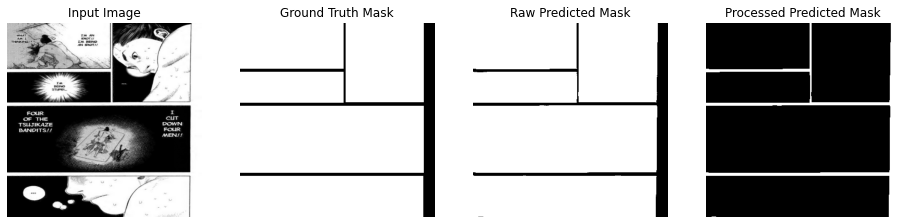

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 2 - Pixel Accuracy: 0.9962 - Precision: 0.9968 - Recall: 0.9990 - F1 Score: 0.9979


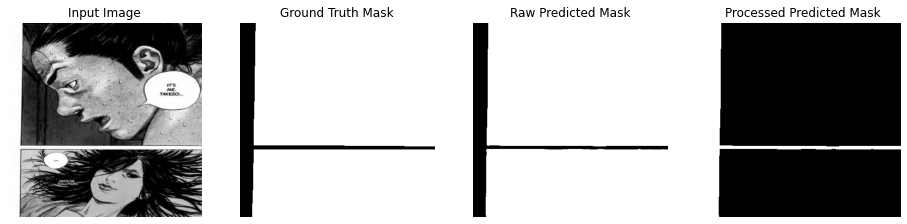

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 3 - Pixel Accuracy: 0.9986 - Precision: 0.9994 - Recall: 0.9991 - F1 Score: 0.9993


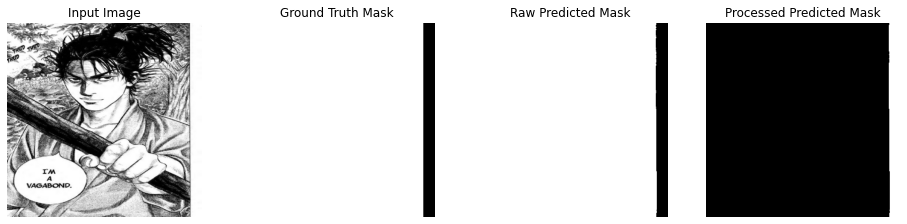

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 4 - Pixel Accuracy: 0.9825 - Precision: 0.9813 - Recall: 0.9990 - F1 Score: 0.9900


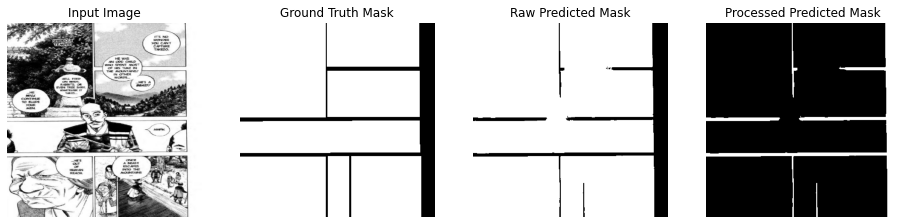

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 5 - Pixel Accuracy: 0.9903 - Precision: 0.9908 - Recall: 0.9983 - F1 Score: 0.9945


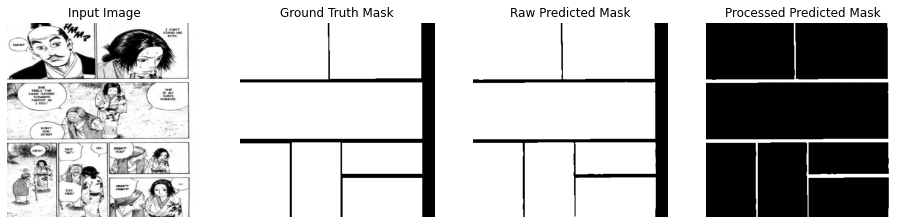

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 6 - Pixel Accuracy: 0.9961 - Precision: 0.9968 - Recall: 0.9989 - F1 Score: 0.9979


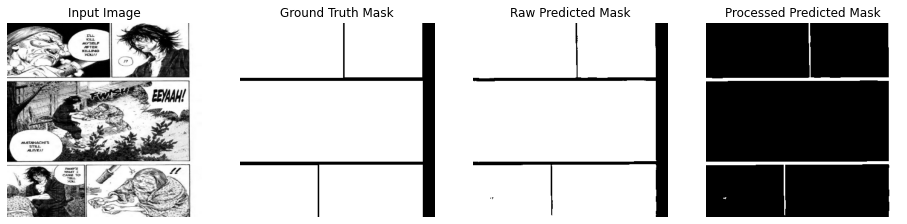

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 7 - Pixel Accuracy: 0.9910 - Precision: 0.9920 - Recall: 0.9981 - F1 Score: 0.9950


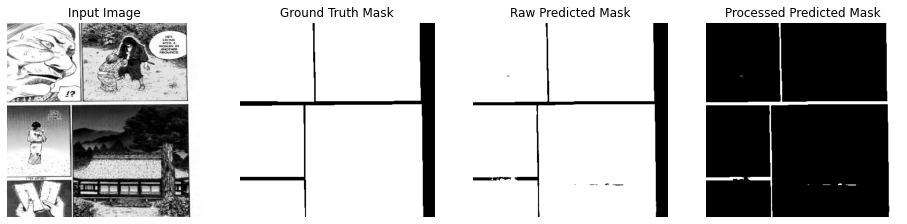

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 8 - Pixel Accuracy: 0.9876 - Precision: 0.9871 - Recall: 0.9987 - F1 Score: 0.9929


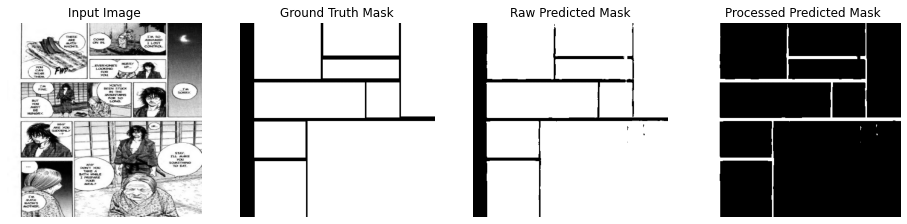

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample 9 - Pixel Accuracy: 0.9907 - Precision: 0.9897 - Recall: 0.9999 - F1 Score: 0.9948


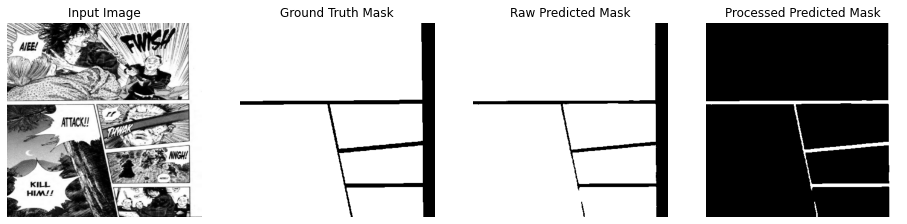

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 10 - Pixel Accuracy: 0.9897 - Precision: 0.9886 - Recall: 0.9996 - F1 Score: 0.9941


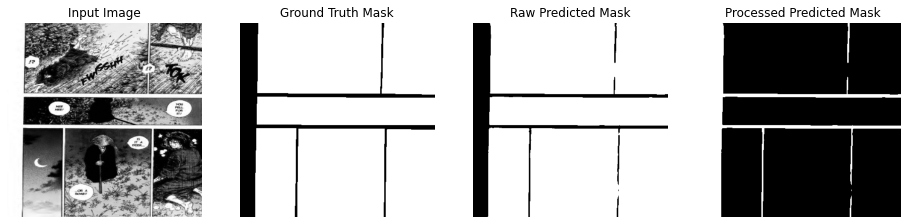

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sample 11 - Pixel Accuracy: 0.9931 - Precision: 0.9956 - Recall: 0.9967 - F1 Score: 0.9962


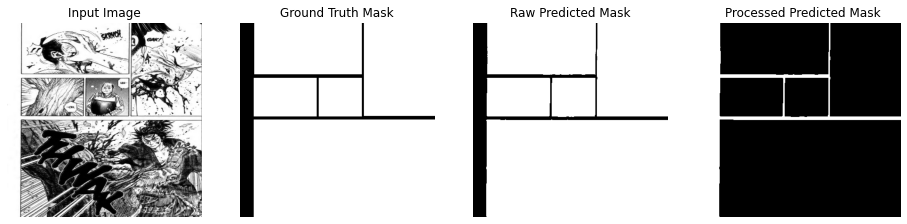

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample 12 - Pixel Accuracy: 0.9920 - Precision: 0.9917 - Recall: 0.9994 - F1 Score: 0.9955


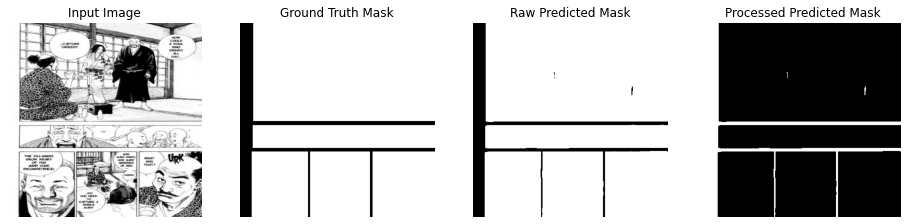

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample 13 - Pixel Accuracy: 0.9926 - Precision: 0.9932 - Recall: 0.9983 - F1 Score: 0.9957


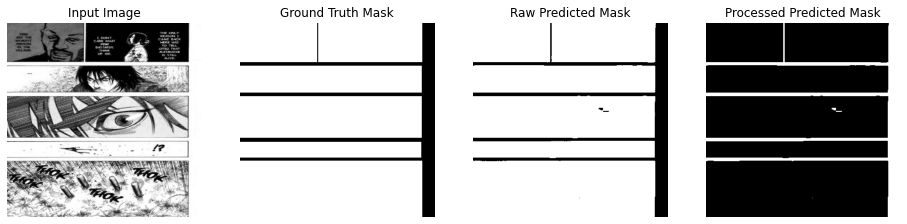

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 14 - Pixel Accuracy: 0.9944 - Precision: 0.9941 - Recall: 0.9999 - F1 Score: 0.9970


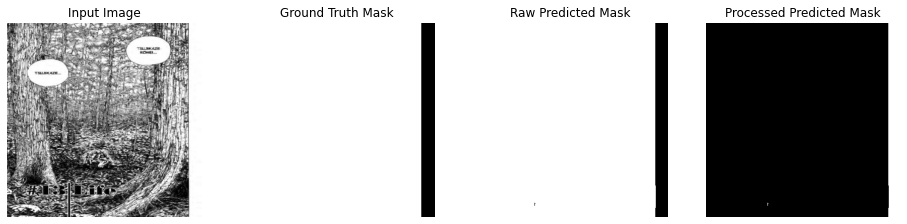

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample 15 - Pixel Accuracy: 0.9918 - Precision: 0.9934 - Recall: 0.9973 - F1 Score: 0.9953


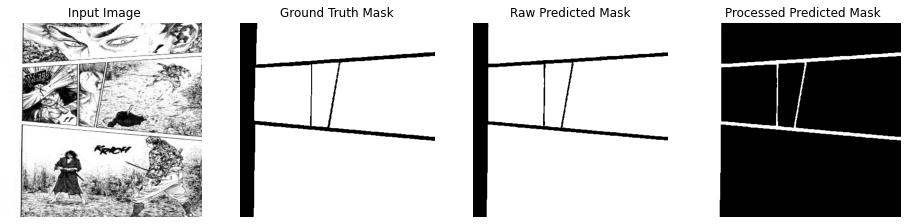

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sample 16 - Pixel Accuracy: 0.9928 - Precision: 0.9942 - Recall: 0.9977 - F1 Score: 0.9959


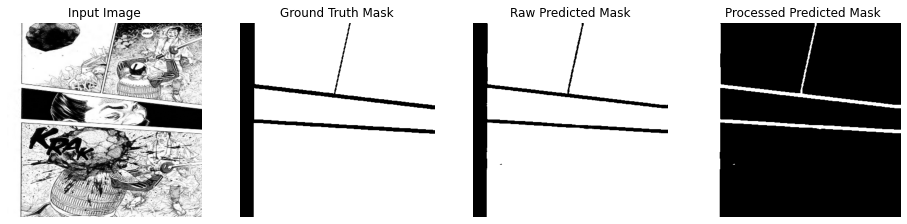

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 17 - Pixel Accuracy: 0.9973 - Precision: 0.9980 - Recall: 0.9991 - F1 Score: 0.9985


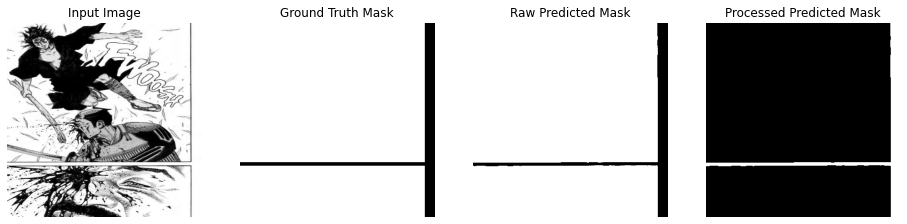

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sample 18 - Pixel Accuracy: 0.9875 - Precision: 0.9891 - Recall: 0.9968 - F1 Score: 0.9930


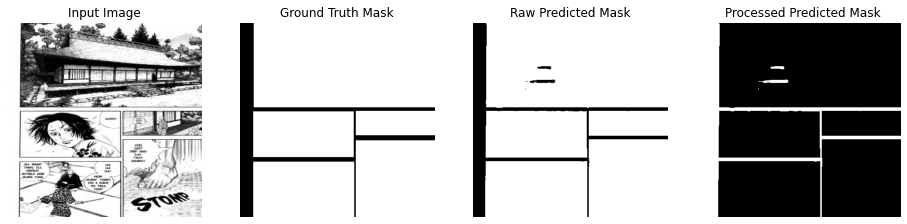

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample 19 - Pixel Accuracy: 0.9904 - Precision: 0.9948 - Recall: 0.9946 - F1 Score: 0.9947


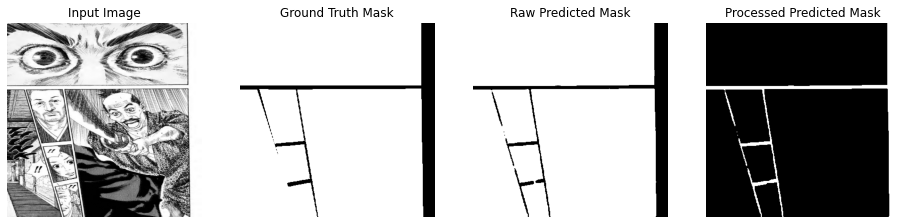

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sample 20 - Pixel Accuracy: 0.9884 - Precision: 0.9899 - Recall: 0.9969 - F1 Score: 0.9934


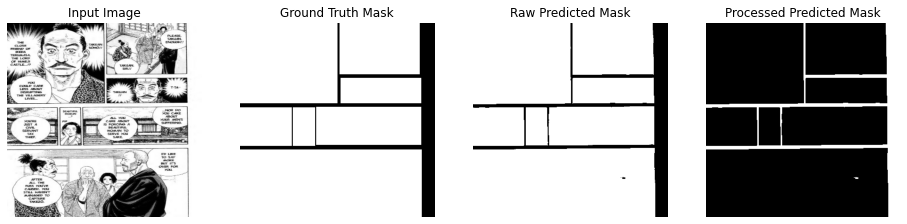

Average Pixel Accuracy: 0.9919
Average Precision: 0.9926
Average Recall: 0.9983
Average F1 Score: 0.9954


In [13]:
test_images, test_masks = load_images_and_masks('Panel-extraction-2/test')

pixel_accuracies = []
pixel_precisions = []
pixel_recalls = []
pixel_f1s = []

for i in range(20): 
    img = test_images[i]
    true_mask = test_masks[i]

    pred_mask = model_250.predict(img[np.newaxis, ...])[0]
    processed_mask = 1 - post_process_mask(pred_mask)

    metrics = calculate_metrics(pred_mask, true_mask)
    pixel_accuracies.append(metrics['pixel_accuracy'])
    pixel_precisions.append(metrics['precision'])
    pixel_recalls.append(metrics['recall'])
    pixel_f1s.append(metrics['f1_score'])
    
    print(f"Sample {i+1} - Pixel Accuracy: {metrics['pixel_accuracy']:.4f} - Precision: {metrics['precision']:.4f} - Recall: {metrics['recall']:.4f} - F1 Score: {metrics['f1_score']:.4f}")
    plot_predictions_post_processing(img, true_mask, pred_mask, processed_mask)

print(f"Average Pixel Accuracy: {np.mean(pixel_accuracies):.4f}")
print(f"Average Precision: {np.mean(pixel_precisions):.4f}")
print(f"Average Recall: {np.mean(pixel_recalls):.4f}")
print(f"Average F1 Score: {np.mean(pixel_f1s):.4f}")